導入需要套件(非全部都用到)

In [1]:
import itertools
import pandas as pd
import numpy as np
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import datetime

In [ ]:
讓圖片顯示中文(需要另外設定)

In [2]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

讀取檔案並觀察,時間序列分析必須要有欄位與時間有關

In [3]:
df = pd.read_excel(io='C:/ph23d_USD_LST.XLS',)
df

,日期,即期買匯,現金買匯,即期賣匯,現金賣匯
0,2018/11/27,30.83,30.49,30.93,31.16
1,2018/11/28,30.84,30.50,30.94,31.17
2,2018/11/29,30.77,30.43,30.87,31.10
3,2018/11/30,30.79,30.45,30.89,31.12
4,2018/12/03,30.69,30.35,30.79,31.02
...,...,...,...,...,...
242,2019/11/20,30.43,30.09,30.53,30.76
243,2019/11/21,30.46,30.12,30.56,30.79
244,2019/11/22,30.45,30.11,30.55,30.78
245,2019/11/25,30.44,30.10,30.54,30.77


對即期買匯有興趣 看圖形走勢

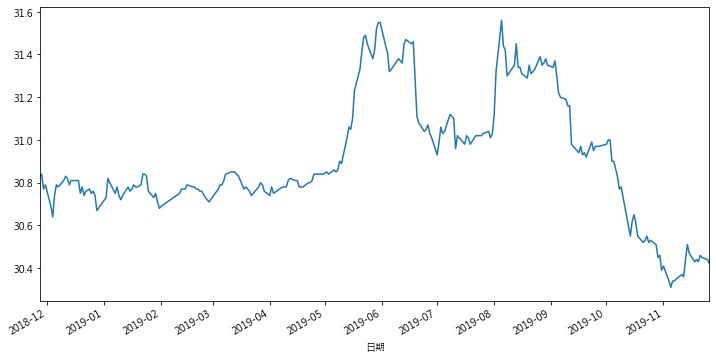

In [21]:
df['即期買匯'].plot(figsize=(12, 6))
plt.show()

檢查有無空值,結果是沒有空值

In [5]:
df.isna().sum()

日期      0
即期買匯    0
現金買匯    0
即期賣匯    0
現金賣匯    0
dtype: int64

讓要的時間成為索引方便做進一步分析

In [6]:
df['日期']=pd.to_datetime(df['日期'])
df=df.set_index('日期') 
df.head()

,即期買匯,現金買匯,即期賣匯,現金賣匯
日期,,,,
2018-11-27,30.83,30.49,30.93,31.16
2018-11-28,30.84,30.50,30.94,31.17
2018-11-29,30.77,30.43,30.87,31.10
2018-11-30,30.79,30.45,30.89,31.12
2018-12-03,30.69,30.35,30.79,31.02


再來看圖形跟上圖比發現x軸變成時間

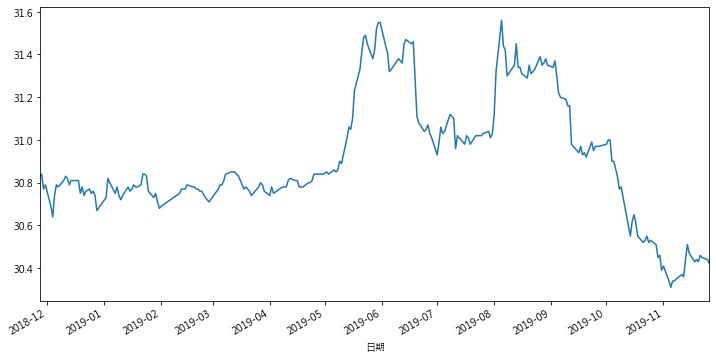

In [7]:
df['即期買匯'].plot(figsize=(12, 6))
plt.show()

這邊使用ARIMA來預測未來時間的數據,參數可自行調整

In [8]:
from statsmodels.tsa.arima_model import ARIMA

In [9]:
model = ARIMA(df['即期買匯'], order=(1, 1, 0))  
fitted = model.fit(disp=0)

C:\Users\isb-03\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\isb-03\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
設定要預測的日期,日期間格為天設置15天

In [10]:
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

這邊需要設定另外做預測的資料欄位
要決定從哪天開始
選(2019,11,26)為資料時間的最後
之後的日期對應資料就是該天預測值
顯示a值是預測日期

In [17]:
fc_arima= pd.DataFrame(fc,columns={'即期買匯'})
def get_nday_list(n):
    after_n_days = []
    for i in range(1, n + 1):
        after_n_days.append((datetime.datetime(2019,11,26) + datetime.timedelta(days=i)).strftime("%Y-%m-%d"))
    return after_n_days

a = get_nday_list(15)
a

['2019-11-27',
 '2019-11-28',
 '2019-11-29',
 '2019-11-30',
 '2019-12-01',
 '2019-12-02',
 '2019-12-03',
 '2019-12-04',
 '2019-12-05',
 '2019-12-06',
 '2019-12-07',
 '2019-12-08',
 '2019-12-09',
 '2019-12-10',
 '2019-12-11']

製作預測表格,觀看資料

In [19]:
a_i=pd.to_datetime(a)
fc_arima=fc_arima.set_index(a_i)
fc_arima

,即期買匯
2019-11-27,30.415847
2019-11-28,30.413840
2019-11-29,30.412124
2019-11-30,30.410447
2019-12-01,30.408775
2019-12-02,30.407104
2019-12-03,30.405433
2019-12-04,30.403762
2019-12-05,30.402091
2019-12-06,30.400420


歷史資料和預測值結合並且繪出圖表
灰色部分是預測值得信賴區間

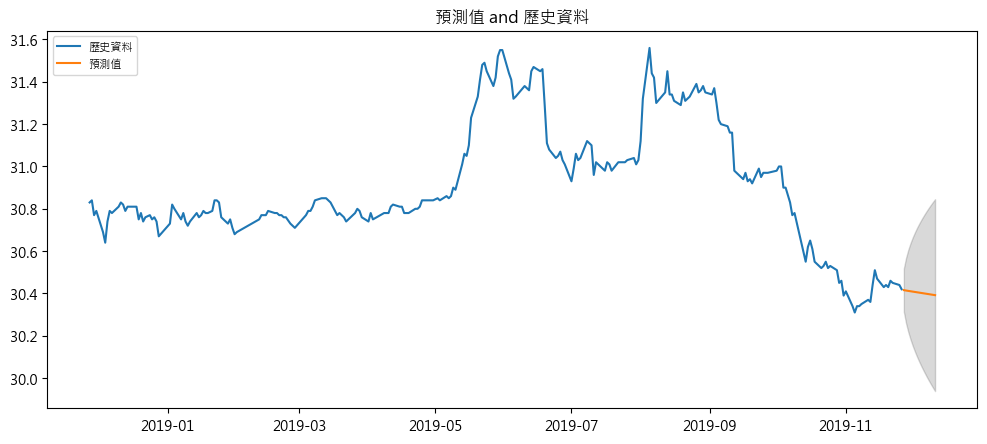

In [20]:
# Make as pandas series
fc_series = pd.Series(fc, index=fc_arima.index)
lower_series = pd.Series(conf[:, 0], index=fc_arima.index)
upper_series = pd.Series(conf[:, 1], index=fc_arima.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['即期買匯'], label='歷史資料')
plt.plot(fc_arima, label='預測值')
#plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('預測值 and 歷史資料')
plt.legend(loc='upper left', fontsize=8)
plt.show()